# Hydroelectric Flow Prediction using Machine Learning

            A. VERMELHA  ESTREITO  FURNAS  I. SOLTEIRA   ITA  ITAIPU  \
Data                                                                   
1950-01-31         3246      1734    1559         6687   349    9898   
1950-02-28         6077      2969    2519        11176   327   16729   
1950-03-31         4213      1863    1581         9200   512   15353   
1950-04-30         3066      1384    1185         6555   356   10164   
1950-05-31         2175      1007     852         4390   629    7498   
...                 ...       ...     ...          ...   ...     ...   
2014-08-31          593       222     200         1964   778    6903   
2014-09-30          458       159     143         1526  1461    7081   
2014-10-31          364       115     102         1212  2108    7423   
2014-11-30          640       307     290         2311   947    6992   
2014-12-31         1589       694     544         5608   842   11492   

            ITAPARICA  ITUMBIARA  JIRAU  JUPIA  ...  P. PRIMAVE

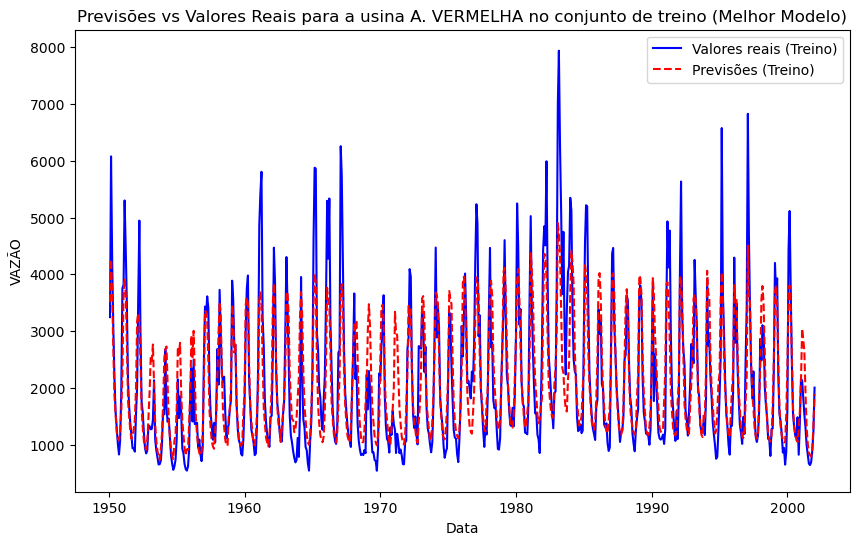

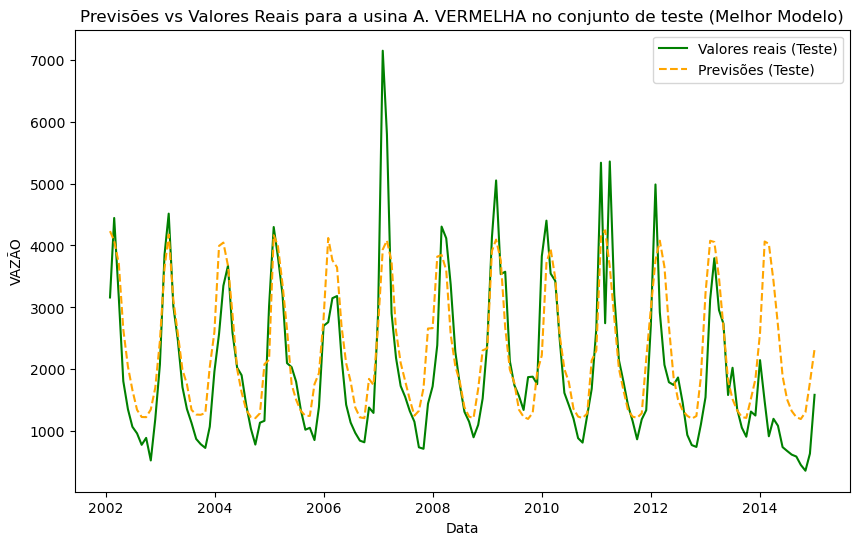

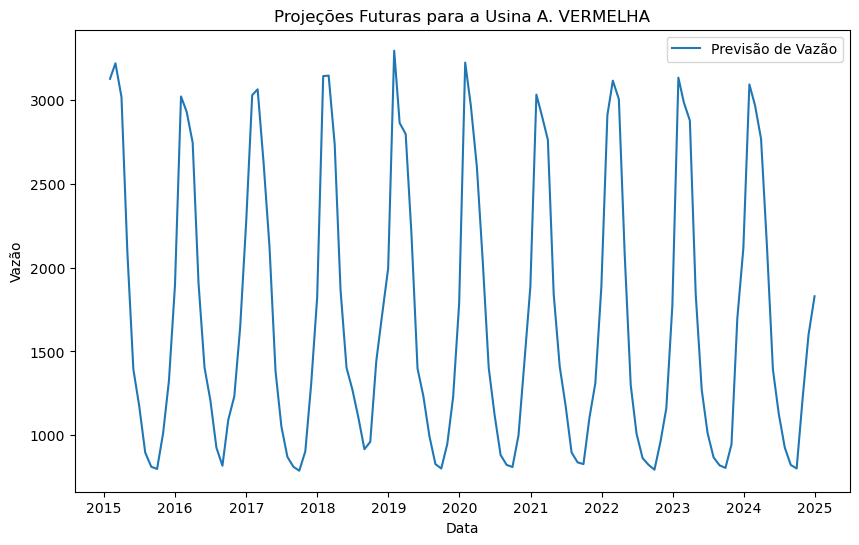


Usina: MARIMBONDO
X:
            Precipitação_Grande  Umidade_Grande  Evapotranspiração_Grande  \
Data                                                                        
1950-01-31             0.000085       39.475288                  0.000050   
1950-02-28             0.000196       43.698528                  0.000042   
1950-03-31             0.000064       40.607208                  0.000045   
1950-04-30             0.000023       38.393085                  0.000038   
1950-05-31             0.000007       35.208004                  0.000031   

            month  year  
Data                     
1950-01-31      1  1950  
1950-02-28      2  1950  
1950-03-31      3  1950  
1950-04-30      4  1950  
1950-05-31      5  1950  
y:
Data
1950-01-31    2889
1950-02-28    5224
1950-03-31    3596
1950-04-30    2610
1950-05-31    1849
Name: MARIMBONDO, dtype: int64
Melhores hiperparâmetros encontrados para a usina MARIMBONDO : {'learning_rate': 0.00541057152066093, 'depth': 8, 'l2_leaf

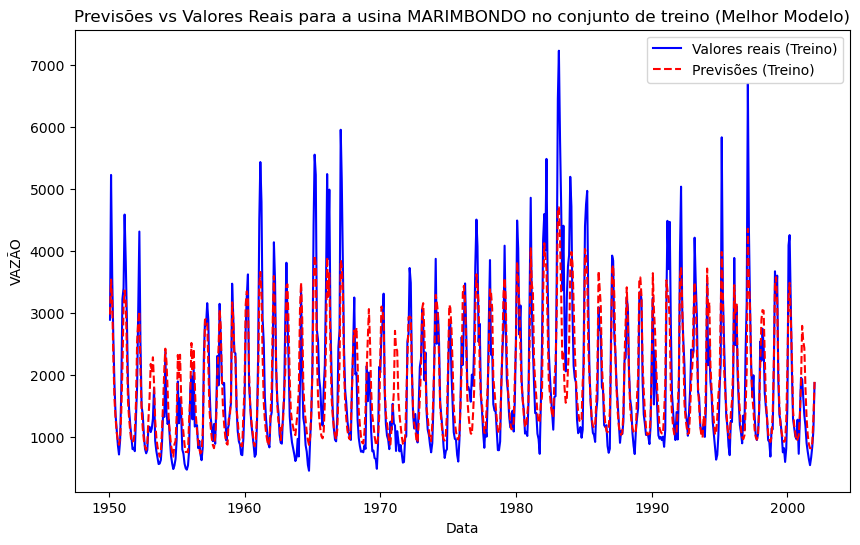

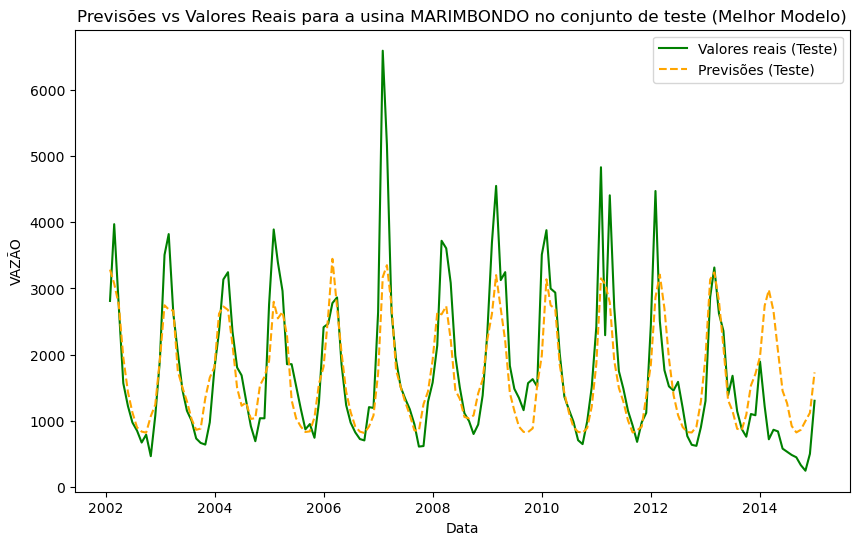

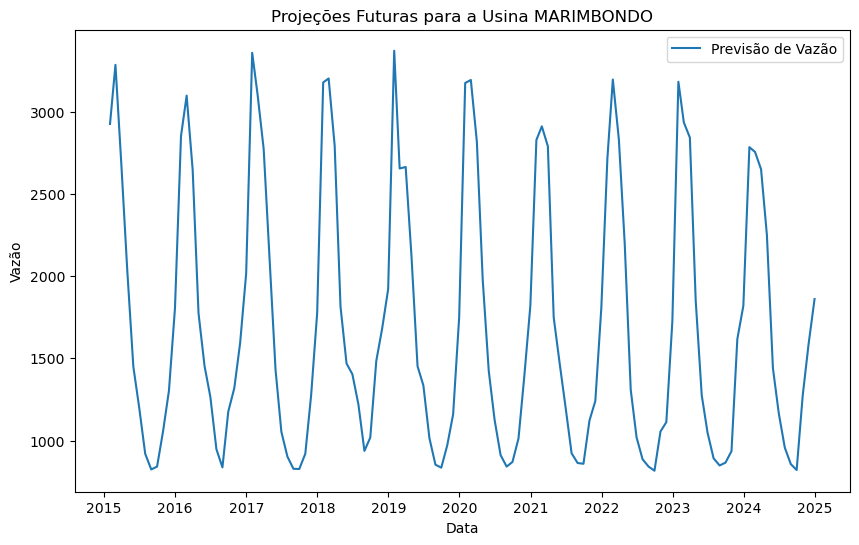


Usina: FURNAS
X:
            Precipitação_Grande  Umidade_Grande  Evapotranspiração_Grande  \
Data                                                                        
1950-01-31             0.000085       39.475288                  0.000050   
1950-02-28             0.000196       43.698528                  0.000042   
1950-03-31             0.000064       40.607208                  0.000045   
1950-04-30             0.000023       38.393085                  0.000038   
1950-05-31             0.000007       35.208004                  0.000031   

            month  year  
Data                     
1950-01-31      1  1950  
1950-02-28      2  1950  
1950-03-31      3  1950  
1950-04-30      4  1950  
1950-05-31      5  1950  
y:
Data
1950-01-31    1559
1950-02-28    2519
1950-03-31    1581
1950-04-30    1185
1950-05-31     852
Name: FURNAS, dtype: int64
Melhores hiperparâmetros encontrados para a usina FURNAS : {'learning_rate': 0.008797285024319599, 'depth': 4, 'l2_leaf_reg': 0.01

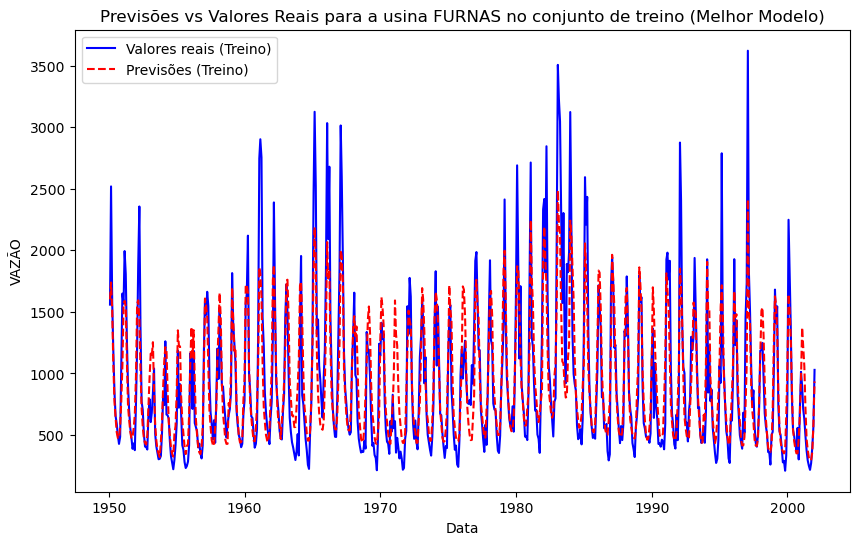

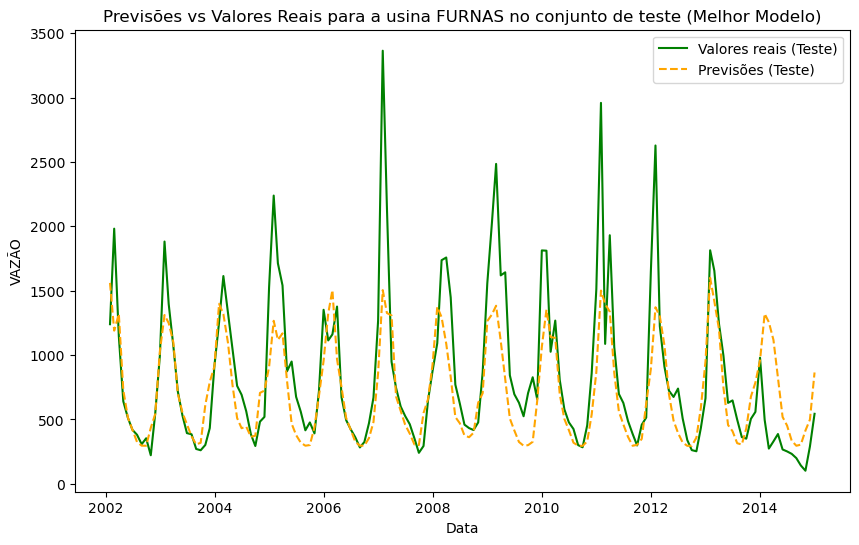

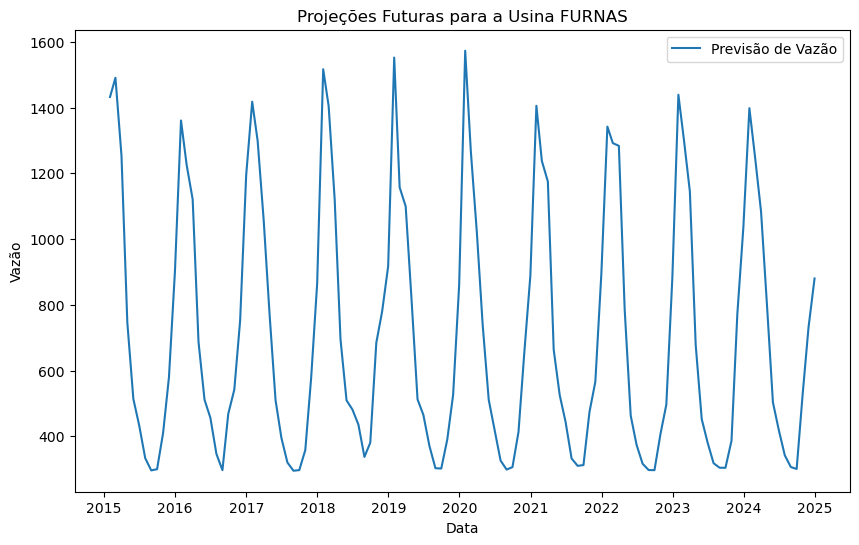


Usina: SANTO ANTONIO
X:
            Precipitação_Madeira  Umidade_Madeira  Evapotranspiração_Madeira  \
Data                                                                           
1950-01-31              0.000132        33.750095                   0.000052   
1950-02-28              0.000114        35.942165                   0.000056   
1950-03-31              0.000132        38.415062                   0.000053   
1950-04-30              0.000064        36.594395                   0.000053   
1950-05-31              0.000018        31.612640                   0.000051   

            month  year  
Data                     
1950-01-31      1  1950  
1950-02-28      2  1950  
1950-03-31      3  1950  
1950-04-30      4  1950  
1950-05-31      5  1950  
y:
Data
1950-01-31    22101
1950-02-28    29122
1950-03-31    35309
1950-04-30    34523
1950-05-31    27291
Name: SANTO ANTONIO, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
import optuna

# Set Optuna logging level to WARNING (hides INFO messages)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Load Excel files containing historical data (1950-2014)
df_prec_umid = pd.read_excel(r'C:\Users\angel\OneDrive\Documentos\Documentos\Bradesco\Projeto\DanosFinanceiros\Usinas\SIN\Dados\Novo\MIROC6\Precipitação_Umidade_Evapotranspiração_1950_2014.xlsx', decimal=',')
df_vazao = pd.read_excel(r'C:\Users\angel\OneDrive\Documentos\Documentos\Bradesco\Projeto\DanosFinanceiros\Usinas\SIN\Dados\Novo\MIROC6\Vazões_1950_2014.xlsx', decimal=',')

# Convert date column to datetime and set as index for flow data
df_vazao['Data'] = pd.to_datetime(df_vazao['Data'])
df_vazao.set_index('Data', inplace=True)

# Add temporal features (year and month) for seasonality modeling
df_vazao['year'] = df_vazao.index.year
df_vazao['month'] = df_vazao.index.month

print(df_vazao)

# Convert date column and set index for precipitation/humidity/evapotranspiration data
df_prec_umid['Data'] = pd.to_datetime(df_prec_umid['Data'])
df_prec_umid.set_index('Data', inplace=True)

# Adjust dates to end-of-month for proper alignment with monthly data
df_prec_umid.index = df_prec_umid.index + pd.offsets.MonthEnd(0)

# Combine flow data with meteorological data using inner join
df_combined = pd.concat([df_vazao, df_prec_umid], axis=1, join='inner')

# Define power plants and their corresponding basins
dados = {
    "Usinas": [
        "A. VERMELHA", "MARIMBONDO", "FURNAS", "SANTO ANTONIO", "JIRAU", "ITAIPU", "I. SOLTEIRA",
        "P. PRIMAVERA", "JUPIA", "TUCURUI", "ESTREITO",
        "P. AFONSO", "XINGO", "ITAPARICA", "SAO SIMAO", "ITUMBIARA", "TELES PIRES", "ITA", "SERRA MESA" 
    ],
    "Bacias": [
        "Grande", "Grande", "Grande", "Madeira", "Madeira", "Paraná, Paranapanema, Amambaí e outros",
        "Paraná, Tietê e outros", "Paraná, Verde, Peixe e outros", "Paraná, Verde, Peixe e outros",
        "Tocantins, entre o rio Araguaia e a foz",
        "Tocantins, entre os rios do Sono e Araguaia", "São Francisco, a jusante do Pajeú",
        "São Francisco, a jusante do Pajeú", "São Francisco, a jusante do Pajeú", "Paranaíba",
        "Paranaíba", "Tapajós", "Uruguai, Chapecó, Passo Fundo e outros", "Alto Tocantins e rio Preto"
    ]
}

# Create DataFrame mapping power plants to their basins
df_usinas_bacias = pd.DataFrame(dados)

# Initialize lists for storing future predictions and results
previsoes_futuras = []
resultados = []

# Define number of time series splits for cross-validation
n_splits = 4

# Load future meteorological data (2015-2024) for predictions
df_prec_umid_futuro = pd.read_excel(r'C:\Users\angel\OneDrive\Documentos\Documentos\Bradesco\Projeto\DanosFinanceiros\Usinas\SIN\Dados\Novo\MIROC6\Precipitacao_Umidade_Evapotranspiração_2015_2024.xlsx', decimal=',')

# Process future data similarly to historical data
df_prec_umid_futuro['Data'] = pd.to_datetime(df_prec_umid_futuro['Data'])
df_prec_umid_futuro.set_index('Data', inplace=True)
df_prec_umid_futuro.index = df_prec_umid_futuro.index + pd.offsets.MonthEnd(0)

# Iterate through each power plant for individual model training
for usina in df_usinas_bacias['Usinas']:
    # Extract target variable (flow) for current power plant
    y = df_combined[usina]
    
    # Get corresponding basin for the power plant
    bacia = df_usinas_bacias[df_usinas_bacias["Usinas"] == usina]["Bacias"].values[0]
    
    # Create feature matrix with meteorological data and temporal features
    X = df_combined[[f'Precipitação_{bacia}', f'Umidade_{bacia}', f'Evapotranspiração_{bacia}', 'month', 'year']]

    # Display data overview for verification
    print(f"\nUsina: {usina}")
    print("X:")
    print(X.head())
    print("y:")
    print(y.head())

    # Standardize features using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Define objective function for Optuna hyperparameter optimization
    def objective(trial):
        # Suggest hyperparameters within defined ranges
        params = {
            "iterations": 1000,
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "depth": trial.suggest_int("depth", 1, 10),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10, log=True),
            "random_strength": trial.suggest_float("random_strength", 1e-9, 10, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 10),
            "border_count": trial.suggest_int("border_count", 1, 255),
            "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        }
    
        # Configure TimeSeriesSplit for cross-validation
        tscv = TimeSeriesSplit(n_splits=n_splits)
        rmse_splits = []
    
        # Perform cross-validation across time series splits
        for train_index, test_index in tscv.split(X_scaled):
            X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
            y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
            # Train CatBoost model with current parameters
            model = CatBoostRegressor(
                iterations=params['iterations'],
                learning_rate=params['learning_rate'],
                depth=params['depth'],
                l2_leaf_reg=params['l2_leaf_reg'],
                random_strength=params['random_strength'],
                bagging_temperature=params['bagging_temperature'],
                border_count=params['border_count'],
                one_hot_max_size=params['one_hot_max_size'],
                subsample=params['subsample'],
                colsample_bylevel=params['colsample_bylevel'],
                min_data_in_leaf=params['min_data_in_leaf'],
                verbose=0
            )
            model.fit(X_train_cv, y_train_cv)
    
            # Generate predictions and calculate RMSE
            predictions_cv = model.predict(X_test_cv)
            rmse_cv = np.sqrt(mean_squared_error(y_test_cv, predictions_cv))
            rmse_splits.append(rmse_cv)
    
        # Return average RMSE across all splits (optimization target)
        return np.mean(rmse_splits)

    # Configure and run Optuna optimization study
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50, timeout=600)

    # Extract best hyperparameters
    best_params = study.best_params
    print("Melhores hiperparâmetros encontrados para a usina", usina, ":", best_params)

    # Train final model with optimized hyperparameters
    model = CatBoostRegressor(
        learning_rate=best_params['learning_rate'],
        depth=best_params['depth'],
        subsample=best_params['subsample'],
        colsample_bylevel=best_params['colsample_bylevel'],
        min_data_in_leaf=best_params['min_data_in_leaf'],
        verbose=0
    )

    # Initialize lists for storing metrics across splits
    mae_treino_splits = []
    mse_treino_splits = []
    rmse_treino_splits = []
    r2_treino_splits = []
    r2_ajustado_treino_splits = []
    mae_teste_splits = []
    mse_teste_splits = []
    rmse_teste_splits = []
    r2_teste_splits = []
    r2_ajustado_teste_splits = []
    predictions_splits = []

    # Perform final evaluation using TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Train and evaluate model for each split
    for i, (train_index, test_index) in enumerate(tscv.split(X_scaled)):
        X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Train model on current split
        model.fit(X_train_cv, y_train_cv)

        # Generate predictions for test set
        predictions_cv = model.predict(X_test_cv)
        predictions_splits.append(predictions_cv)

        # Calculate training set metrics
        predictions_train_cv = model.predict(X_train_cv)
        mae_treino_cv = mean_absolute_error(y_train_cv, predictions_train_cv)
        mse_treino_cv = mean_squared_error(y_train_cv, predictions_train_cv)
        rmse_treino_cv = np.sqrt(mse_treino_cv)
        r2_treino_cv = r2_score(y_train_cv, predictions_train_cv)
        r2_ajustado_treino_cv = 1 - (1 - r2_treino_cv) * (len(y_train_cv) - 1) / (len(y_train_cv) - X_train_cv.shape[1] - 1)

        # Calculate test set metrics
        mae_teste_cv = mean_absolute_error(y_test_cv, predictions_cv)
        mse_teste_cv = mean_squared_error(y_test_cv, predictions_cv)
        rmse_teste_cv = np.sqrt(mse_teste_cv)
        r2_teste_cv = r2_score(y_test_cv, predictions_cv)
        r2_ajustado_teste_cv = 1 - (1 - r2_teste_cv) * (len(y_test_cv) - 1) / (len(y_test_cv) - X_test_cv.shape[1] - 1)

        # Store all metrics
        mae_treino_splits.append(mae_treino_cv)
        mse_treino_splits.append(mse_treino_cv)
        rmse_treino_splits.append(rmse_treino_cv)
        r2_treino_splits.append(r2_treino_cv)
        r2_ajustado_treino_splits.append(r2_ajustado_treino_cv)
        mae_teste_splits.append(mae_teste_cv)
        mse_teste_splits.append(mse_teste_cv)
        rmse_teste_splits.append(rmse_teste_cv)
        r2_teste_splits.append(r2_teste_cv)
        r2_ajustado_teste_splits.append(r2_ajustado_teste_cv)

    # Select best model based on highest adjusted R² on test set
    best_index = np.argmax(r2_ajustado_teste_splits)

    # Display performance metrics for best model
    print('\n--- Métricas do melhor modelo para o conjunto de treino ---')
    print('Erro Médio Absoluto (MAE):', mae_treino_splits[best_index])
    print('Erro Quadrático Médio (MSE):', mse_treino_splits[best_index])
    print('Raiz do Erro Quadrático Médio (RMSE):', rmse_treino_splits[best_index])
    print('Coeficiente de Determinação (R²):', r2_treino_splits[best_index])
    print('R² ajustado:', r2_ajustado_treino_splits[best_index])

    print('\n--- Métricas do melhor modelo para o conjunto de teste ---')
    print('Erro Médio Absoluto (MAE):', mae_teste_splits[best_index])
    print('Erro Quadrático Médio (MSE):', mse_teste_splits[best_index])
    print('Raiz do Erro Quadrático Médio (RMSE):', rmse_teste_splits[best_index])
    print('Coeficiente de Determinação (R²):', r2_teste_splits[best_index])
    print('R² ajustado:', r2_ajustado_teste_splits[best_index])

    # Extract predictions from best model
    best_predictions = predictions_splits[best_index]

    # Plot training set results
    plt.figure(figsize=(10, 6))
    plt.plot(df_combined.index[:len(y_train_cv)], y_train_cv, label='Valores reais (Treino)', color='blue')
    plt.plot(df_combined.index[:len(y_train_cv)], model.predict(X_train_cv), label='Previsões (Treino)', color='red', linestyle='--')
    plt.xlabel('Data')
    plt.ylabel('VAZÃO')
    plt.title(f'Previsões vs Valores Reais para a usina {usina} no conjunto de treino (Melhor Modelo)')
    plt.legend()
    plt.show()

    # Plot test set results
    plt.figure(figsize=(10, 6))
    plt.plot(df_combined.index[len(y_train_cv):], y_test_cv, label='Valores reais (Teste)', color='green')
    plt.plot(df_combined.index[len(y_train_cv):], best_predictions, label='Previsões (Teste)', color='orange', linestyle='--')
    plt.xlabel('Data')
    plt.ylabel('VAZÃO')
    plt.title(f'Previsões vs Valores Reais para a usina {usina} no conjunto de teste (Melhor Modelo)')
    plt.legend()
    plt.show()

    # Store results for final summary
    resultados.append({
        'Usina': usina,
        'MAE Treino': mae_treino_splits[best_index],
        'MAE Teste': mae_teste_splits[best_index],
        'MSE Treino': mse_treino_splits[best_index],
        'MSE Teste': mse_teste_splits[best_index],
        'RMSE Treino': rmse_treino_splits[best_index],
        'RMSE Teste': rmse_teste_splits[best_index],
        'R2 Treino': r2_treino_splits[best_index],
        'R2 Teste': r2_teste_splits[best_index],
        'R2 Ajustado Treino': r2_ajustado_treino_splits[best_index],
        'R2 Ajustado Teste': r2_ajustado_teste_splits[best_index],
    })

    # Prepare future features for prediction (2015-2024)
    X_futuro = df_prec_umid_futuro[[f'Precipitação_{bacia}', f'Umidade_{bacia}', f'Evapotranspiração_{bacia}']].copy()
    X_futuro.loc[:, 'month'] = df_prec_umid_futuro.index.month
    X_futuro.loc[:, 'year'] = df_prec_umid_futuro.index.year

    # Standardize future data using same scaler
    X_futuro_scaled = scaler.transform(X_futuro)

    # Generate future predictions
    previsoes_futuras_usina = model.predict(X_futuro_scaled)
    
    # Store future predictions
    previsoes_futuras.append(pd.DataFrame({
        'Data': df_prec_umid_futuro.index,
        'Usina': usina,
        'Previsao_Vazao': previsoes_futuras_usina
    }))

    # Plot future projections
    plt.figure(figsize=(10, 6))
    plt.plot(df_prec_umid_futuro.index, previsoes_futuras_usina, label='Previsão de Vazão')
    plt.title(f'Projeções Futuras para a Usina {usina}')
    plt.xlabel('Data')
    plt.ylabel('Vazão')
    plt.legend()
    plt.show()

# Combine all future predictions into single DataFrame
previsoes_futuras_df = pd.concat(previsoes_futuras, ignore_index=True)

# Export future predictions to Excel
previsoes_futuras_df.to_excel(r'C:\Users\angel\OneDrive\Documentos\Documentos\Bradesco\Projeto\DanosFinanceiros\Usinas\SIN\Dados\Novo\MIROC6\Vazões_futuras_2015_2024_PUE_novo.xlsx', index=False)

# Create results summary DataFrame
resultados_df = pd.DataFrame(resultados)

# Display final results
print(resultados_df)

# Export model performance results to Excel
#resultados_df.to_excel(r'C:\Users\angel\OneDrive\Documentos\Documentos\Bradesco\Projeto\DanosFinanceiros\Usinas\SIN\Dados\Novo\MIROC6\resultados_modelo_2015_2024_PUE_novo.xlsx', index=False)

## Comparison of Future Test Predictions (2015–2022) with Actual Values

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load actual flow data from Excel file (2015-2022 period)
Vazão_Real = pd.read_excel(r'C:\Users\angel\OneDrive\Documentos\Documentos\Bradesco\Projeto\DanosFinanceiros\Usinas\SIN\Dados\Novo\MIROC6\Vazões_2015_2022.xlsx')

# Convert date column to datetime format and set as index
Vazão_Real['Data'] = pd.to_datetime(Vazão_Real['Data'])
Vazão_Real.set_index('Data', inplace=True)

# Resample actual flow data to monthly median values for consistent comparison
# 'ME' stands for Month End frequency (replaces deprecated 'M')
Vazão_Real_mensal = Vazão_Real.resample('ME').median()

# Load predicted flow data from Excel file (model predictions for 2015-2022)
Vazão_Prevista = pd.read_excel(r'C:\Users\angel\OneDrive\Documentos\Documentos\Bradesco\Projeto\DanosFinanceiros\Usinas\SIN\Dados\Novo\MIROC6\Vazões_futuras_2015_2022_PUE.xlsx')

# Convert prediction date column to datetime and set as index
Vazão_Prevista['Data'] = pd.to_datetime(Vazão_Prevista['Data'])
Vazão_Prevista.set_index('Data', inplace=True)

# Extract list of power plant names (all columns except date)
# This assumes the first column onwards contains power plant data
usinas = Vazão_Real.columns[0:]

# Generate comparison plots for each power plant
for usina in usinas:
    # Create figure with specified size for better visibility
    plt.figure(figsize=(12, 6))
    
    # Plot actual flow values with circular markers
    plt.plot(Vazão_Real_mensal.index, Vazão_Real_mensal[usina], 
             label='Vazão Real', marker='o')
    
    # Plot predicted flow values with square markers
    plt.plot(Vazão_Prevista.index, Vazão_Prevista[usina], 
             label='Vazão Prevista', marker='s')
    
    # Configure plot appearance and labels
    plt.title(f'Vazão Real vs. Vazão Prevista - Usina: {usina}')
    plt.xlabel('Data')
    plt.ylabel('Vazão')
    plt.legend()
    plt.grid(True)  # Add grid for better readability
    
    # Format x-axis to show dates in YYYY-MM format
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # Set major tick intervals to every 6 months for cleaner x-axis
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent label cutoff and display plot
    plt.tight_layout()
    plt.show()

# ENA (Natural Energy Affluence)

In [ ]:
import pandas as pd

# Load predicted flow data from Excel file (SSP245 climate scenario)
# This file contains future flow predictions generated by the ML model
Vazão_ssp245 = pd.read_excel(r'C:\Users\angel\OneDrive\Documentos\Documentos\Bradesco\Projeto\DanosFinanceiros\Usinas\SIN\Dados\Novo\MIROC6\Vazões_futuras_2015_2024_PUE_ssp245_teste2.xlsx')

# Convert date column to datetime format for proper time series handling
Vazão_ssp245['Data'] = pd.to_datetime(Vazão_ssp245['Data'])

# Set date column as index to enable time series operations
Vazão_ssp245.set_index('Data', inplace=True)

# Load productivity coefficients for each reservoir from separate Excel file
# These coefficients convert flow rates (m³/s) to energy production capacity (MW)
# The productivity values represent the energy generation efficiency at 65% useful volume
produtividade_df = pd.read_excel(r'C:\Users\angel\OneDrive\Documentos\Documentos\Bradesco\Projeto\DanosFinanceiros\Usinas\SIN\Dados\val_produtividade65volutil.xlsx')

# Create productivity dictionary mapping reservoir names to their coefficients
# This allows for efficient lookup of productivity values for each power plant
produtividade_dict = produtividade_df.set_index('nom_reservatorio')['val_produtividade65volutil'].to_dict()

# Create new DataFrame for storing ENA (Natural Energy Affluence) values
# ENA represents the energy production potential based on water inflow
ENA_ssp245 = Vazão_ssp245.copy()

# Convert flow predictions to ENA by applying plant-specific productivity coefficients
for usina in ENA_ssp245.columns:
    # Check if productivity coefficient exists for current power plant
    if usina in produtividade_dict:
        # Retrieve productivity coefficient for current plant
        produtividade = produtividade_dict[usina]
        
        # Display conversion information for verification
        print(f"Power Plant: {usina}, Productivity Coefficient: {produtividade}")
        
        # Apply conversion: Flow (m³/s) × Productivity = ENA (MWaverage)
        # This transforms water flow into equivalent energy production capacity
        ENA_ssp245[usina] *= produtividade
    else:
        # Handle case where productivity coefficient is not available
        print(f"Productivity coefficient not found for power plant {usina}, no conversion applied.")

# Display the resulting ENA DataFrame for verification
print("ENA Conversion Results:")
print(ENA_ssp245)

# Export ENA predictions to Excel file for further analysis and reporting
# This file will be used for energy sector planning and grid operations
#ENA_ssp245.to_excel(r'C:\Users\angel\OneDrive\Documentos\Documentos\Bradesco\Projeto\DanosFinanceiros\Usinas\SIN\Dados\Novo\MIROC6\Dash\Angelica_ENA_2025_2050_ssp245_teste2.xlsx', index=True)

print("ENA conversion completed successfully. Results exported to Excel file.")